4

📁 Processing file: datasets_by_window/dataset_majority_win100.pkl
Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.99      0.99      0.99     50366
    Laughter       0.01      0.01      0.01       416

    accuracy                           0.98     50782
   macro avg       0.50      0.50      0.50     50782
weighted avg       0.98      0.98      0.98     50782



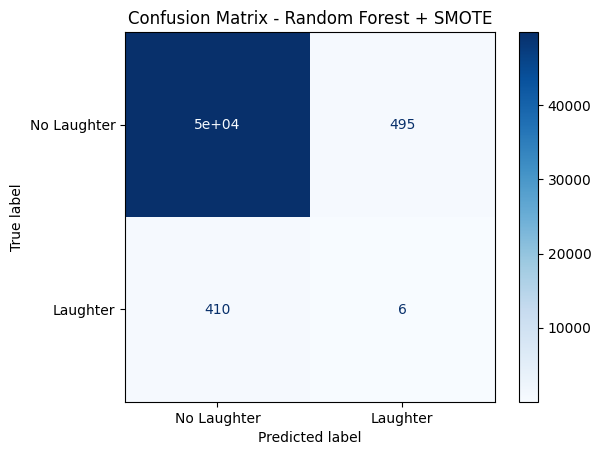


📁 Processing file: datasets_by_window/dataset_majority_win200.pkl
Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.99      0.99      0.99     25075
    Laughter       0.01      0.01      0.01       207

    accuracy                           0.98     25282
   macro avg       0.50      0.50      0.50     25282
weighted avg       0.98      0.98      0.98     25282



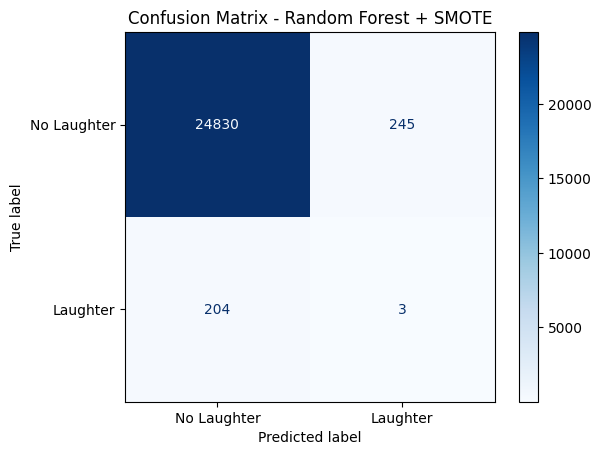


📁 Processing file: datasets_by_window/dataset_union_win100.pkl
Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.96      0.94      0.95     48560
    Laughter       0.09      0.13      0.11      2222

    accuracy                           0.90     50782
   macro avg       0.53      0.54      0.53     50782
weighted avg       0.92      0.90      0.91     50782



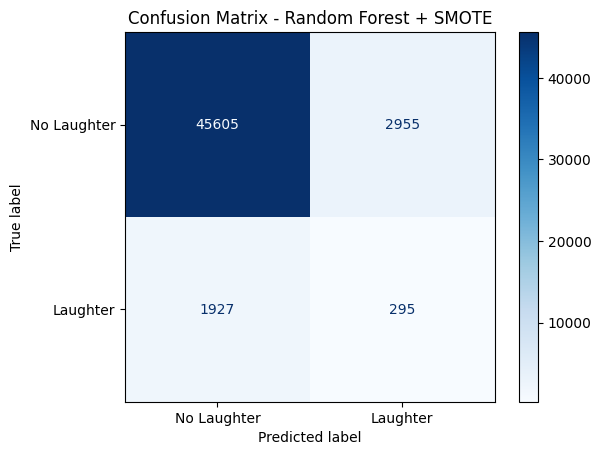


📁 Processing file: datasets_by_window/dataset_union_win200.pkl
Classification Report:
              precision    recall  f1-score   support

 No Laughter       0.96      0.94      0.95     24166
    Laughter       0.08      0.11      0.09      1116

    accuracy                           0.90     25282
   macro avg       0.52      0.53      0.52     25282
weighted avg       0.92      0.90      0.91     25282



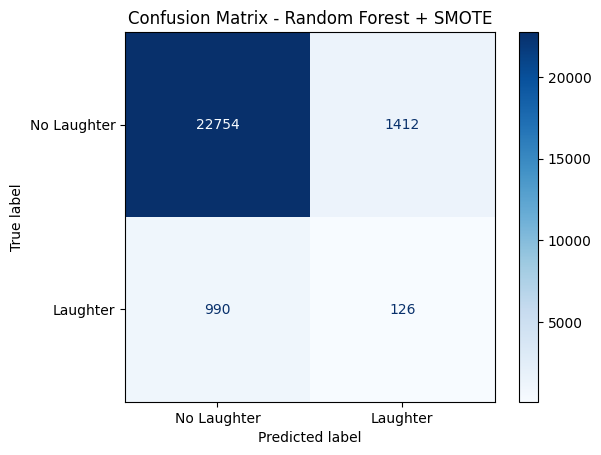

In [8]:
import pickle
import os
import numpy as np
from glob import glob

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

file_paths = sorted(glob("datasets_by_window/*.pkl"))

print(len(file_paths))

for path in file_paths:
    print(f"\n📁 Processing file: {path}")

    # --- Cargar datos ---
    with open(path, "rb") as f:
        X_total, y_total, resumen_data = pickle.load(f)

    # 1. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_total, y_total, test_size=0.2, stratify=y_total, random_state=42
    )

    # 2. Balance with SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    # 3. Train classifier
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_resampled, y_resampled)

    # 4. Predict and evaluate
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Laughter", "Laughter"]))

    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Laughter", "Laughter"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - Random Forest + SMOTE")
    plt.show()
